In [144]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
from sklearn.model_selection import train_test_split

In [145]:
X_circles, y_circles = make_circles(n_samples=1000, noise=0.05, factor=0.5, random_state=42)

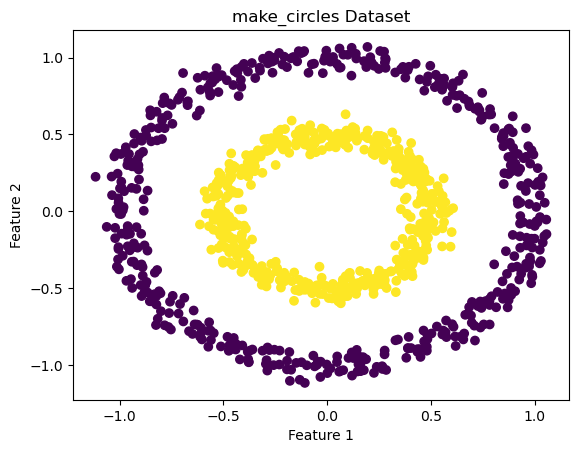

In [146]:
# Plot the generated data
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=y_circles, cmap='viridis')
plt.title("make_circles Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [147]:
moon_df = pd.DataFrame({"X": X_circles[:,0],"Y":  X_circles[:,1],"label": y_circles })
moon_df

,X,Y,label
0,0.452592,0.168433,1
1,-0.438027,0.119900,1
2,-0.532224,0.184359,1
3,-0.301402,0.400782,1
4,0.445602,-0.894936,0
...,...,...,...
995,0.249091,0.925787,0
996,-0.985370,-0.288162,0
997,-0.072016,-0.531447,1
998,0.660905,-0.793190,0


In [148]:
torch.__version__

'2.6.0+cpu'

In [149]:
X = torch.from_numpy(X_circles).type(torch.float)
y = torch.from_numpy(y_circles).type(torch.float)

In [150]:
# train_test_split of the data
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [151]:
print(f""" 
      input Values: {X_train[:5]}
      output_label: {y_train[:5]}
      
      """)

 
      input Values: tensor([[ 0.4413, -0.2603],
        [ 0.6030, -0.7328],
        [-1.0219, -0.1066],
        [-0.9613, -0.2265],
        [-0.1010,  0.5180]])
      output_label: tensor([1., 0., 0., 0., 1.])
      
      


In [152]:
len(X_train),len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

In [153]:
type(X_train),X_train.dtype, X_train.device, X_train.requires_grad

(torch.Tensor, torch.float32, device(type='cpu'), False)

In [154]:
# building model 
device = "cuda" if torch.cuda.is_available() else "cpu"


class NeuralNetworkClassification(nn.Module):
    """docstring for ."""
    def __init__(self):
        super().__init__()
        # define all the layers of the models
        self.linear1 = nn.Linear(in_features=2, out_features=10)
        self.linear2 = nn.Linear(in_features= 10, out_features= 1)
        self.sigmoid = nn.Sigmoid()
        self.relu= nn.ReLU()
        
        # using sequentail method
        # self.sequential_layer = nn.Sequential(
        #     nn.Linear(in_features=2, out_features=5),
        #     nn.Linear(in_features=5, out_features=1)
        # )
    
    def forward(self,x):
        x = self.linear1(x)
        x= self.linear2(x)
        # we used nn.BCEWithLogitsLoss (which is the combination of Sigmoid and BCELoss) so we don't need to sigmoid here
        # output = self.sigmoid(x)
        return x  
        
        # sequentail method 
        # return self.sequential_layer(x)

    

In [155]:
model = NeuralNetworkClassification().to(device)
model

NeuralNetworkClassification(
  (linear1): Linear(in_features=2, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

In [156]:
model.state_dict()

OrderedDict([('linear1.weight',
              tensor([[ 0.3691,  0.3716],
                      [ 0.2644, -0.1243],
                      [-0.1872,  0.0756],
                      [-0.1249, -0.2107],
                      [ 0.4520,  0.6077],
                      [-0.0700, -0.1583],
                      [ 0.0103, -0.0422],
                      [ 0.1700,  0.1982],
                      [-0.6422, -0.2609],
                      [ 0.5955,  0.2755]])),
             ('linear1.bias',
              tensor([-0.0352, -0.4263, -0.4326, -0.6334, -0.2305,  0.2388,  0.4509,  0.3265,
                      -0.6250, -0.4252])),
             ('linear2.weight',
              tensor([[-0.0499,  0.3059,  0.0457, -0.0819,  0.1308, -0.1204, -0.2047,  0.2308,
                       -0.1438, -0.0634]])),
             ('linear2.bias', tensor([-0.3146]))])

In [157]:
# loss and optimizer for the classification problem
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters())

In [158]:
model.eval()
with torch.inference_mode():
    y_logits = model(X_test)[:5]

y_logits

tensor([[-0.3615],
        [-0.2288],
        [-0.4870],
        [-0.2921],
        [-0.3936]])

In [159]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [160]:
y_pred_test= torch.round(torch.sigmoid(y_logits))
y_pred_test.squeeze()

tensor([0., 0., 0., 0., 0.])

### Training and Testing loop 

In [161]:
def accuracy(y_pred, y_true):
    # TP + FP/ TP+FP +FN + FP
   return ((torch.eq(y_pred,y_true).sum())/len(y_true)) *100

In [162]:
# putting the data into device according 
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
print(X_test.device)

cpu


In [163]:
# training and testing loop 
torch.manual_seed(42)
epochs = 300

for epoch in range(epochs):
    model.train()
    
    # forward pass 
    y_logits = model(X_train).squeeze() # this are the logits without pass it from the activation function we have used the BCEWithLogits
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    # 2. calculate the loss and Accuracy of the model
    loss = loss_fn(y_logits,y_train) # we are using BCEWithLogitsLoss expects raw logits as input
    
    acc = accuracy(y_pred , y_train)
    
    
    # backpropagation 
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    
    # testing loop 
    
    model.eval()
    with torch.inference_mode():
        y_test_logits = model(X_test).squeeze()
        
        test_loss = loss_fn(y_test_logits,y_test)
        y_test_pred = torch.round(torch.sigmoid(y_test_logits))
        
        test_acc = accuracy(y_test_pred , y_test)
        
        
    if epoch % 10 == 0:
            print(f"Epoch: {epoch} Loss: {loss:.5f} accuracy: {acc:.2f} |  Test loss: {test_loss:.5f} Test Accuracy: {test_acc:.2f} ")
    
    
    
    

Epoch: 0 Loss: 0.71183 accuracy: 50.00 |  Test loss: 0.71704 Test Accuracy: 50.00 
Epoch: 10 Loss: 0.71157 accuracy: 50.00 |  Test loss: 0.71679 Test Accuracy: 50.00 
Epoch: 20 Loss: 0.71132 accuracy: 50.00 |  Test loss: 0.71655 Test Accuracy: 50.00 
Epoch: 30 Loss: 0.71108 accuracy: 50.00 |  Test loss: 0.71630 Test Accuracy: 50.00 
Epoch: 40 Loss: 0.71083 accuracy: 50.00 |  Test loss: 0.71606 Test Accuracy: 50.00 
Epoch: 50 Loss: 0.71059 accuracy: 50.00 |  Test loss: 0.71583 Test Accuracy: 50.00 
Epoch: 60 Loss: 0.71036 accuracy: 50.00 |  Test loss: 0.71560 Test Accuracy: 50.00 
Epoch: 70 Loss: 0.71013 accuracy: 50.00 |  Test loss: 0.71537 Test Accuracy: 50.00 
Epoch: 80 Loss: 0.70990 accuracy: 50.00 |  Test loss: 0.71514 Test Accuracy: 50.00 
Epoch: 90 Loss: 0.70967 accuracy: 50.00 |  Test loss: 0.71492 Test Accuracy: 50.00 
Epoch: 100 Loss: 0.70945 accuracy: 50.00 |  Test loss: 0.71470 Test Accuracy: 50.00 
Epoch: 110 Loss: 0.70923 accuracy: 50.00 |  Test loss: 0.71448 Test Accuracy

In [164]:
from helper_function import plot_decision_boundary

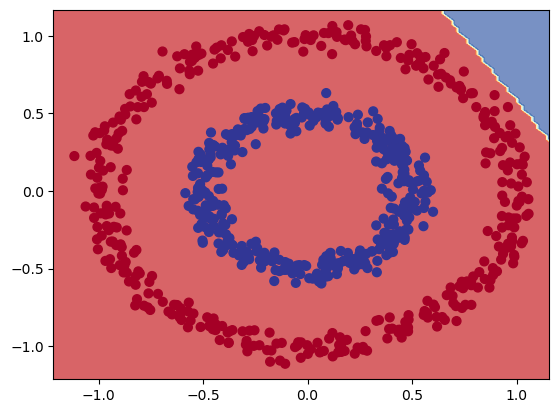

In [165]:
plot_decision_boundary(model,X_train,y_train)

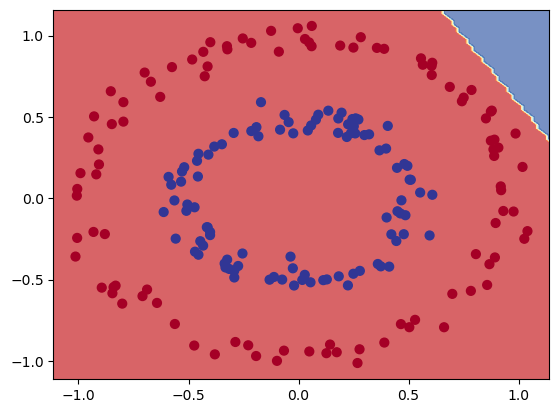

In [166]:
plot_decision_boundary(model,X_test,y_test)

In [167]:
# building model 
device = "cuda" if torch.cuda.is_available() else "cpu"


class NeuralNetworkClassification2(nn.Module):
    """docstring for ."""
    def __init__(self):
        super().__init__()
        # define all the layers of the models
        self.sequential = nn.Sequential( 
                                        nn.Linear(in_features=2, out_features=10),
                                        nn.ReLU(),
                                        nn.Linear(in_features=10, out_features=10),
                                        nn.ReLU(),
                                        # nn.Dropout(p=0.5),
                                        nn.Linear(in_features=10, out_features=1),
                                        )
     
        
        # using sequentail method
        # self.sequential_layer = nn.Sequential(
        #     nn.Linear(in_features=2, out_features=5),
        #     nn.Linear(in_features=5, out_features=1)
        # )
    
    def forward(self,x):
        
        # we used nn.BCEWithLogitsLoss (which is the combination of Sigmoid and BCELoss) so we don't need to sigmoid here
        # output = self.sigmoid(x)
        return self.sequential(x) 
        
        # sequentail method 
        # return self.sequential_layer(x)

    

In [168]:
model2 = NeuralNetworkClassification2()


In [169]:
# loss and optimizer for the classification problem
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model2.parameters(),lr=0.1)

In [170]:
# training and testing loop 
torch.manual_seed(42)
epochs = 1000

for epoch in range(epochs):
    model2.train()
    
    # forward pass 
    y_logits = model2(X_train).squeeze() # this are the logits without pass it from the activation function we have used the BCEWithLogits
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    # 2. calculate the loss and Accuracy of the model
    loss = loss_fn(y_logits,y_train) # we are using BCEWithLogitsLoss expects raw logits as input
    
    acc = accuracy(y_pred , y_train)
    
    
    # backpropagation 
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    
    # testing loop 
    
    model2.eval()
    with torch.inference_mode():
        y_test_logits = model2(X_test).squeeze()
        
        test_loss = loss_fn(y_test_logits,y_test)
        y_test_pred = torch.round(torch.sigmoid(y_test_logits))
        
        test_acc = accuracy(y_test_pred , y_test)
        
        
    if epoch % 100 == 0:
            print(f"Epoch: {epoch} Loss: {loss:.5f} accuracy: {acc:.2f} |  Test loss: {test_loss:.5f} Test Accuracy: {test_acc:.2f} ")
    
    
    
    

Epoch: 0 Loss: 0.69355 accuracy: 50.00 |  Test loss: 0.69369 Test Accuracy: 50.00 
Epoch: 100 Loss: 0.68407 accuracy: 62.63 |  Test loss: 0.68381 Test Accuracy: 62.50 
Epoch: 200 Loss: 0.66352 accuracy: 67.12 |  Test loss: 0.66286 Test Accuracy: 69.00 
Epoch: 300 Loss: 0.61055 accuracy: 79.00 |  Test loss: 0.60784 Test Accuracy: 78.00 
Epoch: 400 Loss: 0.49171 accuracy: 88.62 |  Test loss: 0.48806 Test Accuracy: 90.50 
Epoch: 500 Loss: 0.26501 accuracy: 99.25 |  Test loss: 0.27231 Test Accuracy: 98.50 
Epoch: 600 Loss: 0.11323 accuracy: 100.00 |  Test loss: 0.12594 Test Accuracy: 100.00 
Epoch: 700 Loss: 0.05776 accuracy: 100.00 |  Test loss: 0.06913 Test Accuracy: 100.00 
Epoch: 800 Loss: 0.03497 accuracy: 100.00 |  Test loss: 0.04447 Test Accuracy: 100.00 
Epoch: 900 Loss: 0.02387 accuracy: 100.00 |  Test loss: 0.03173 Test Accuracy: 100.00 


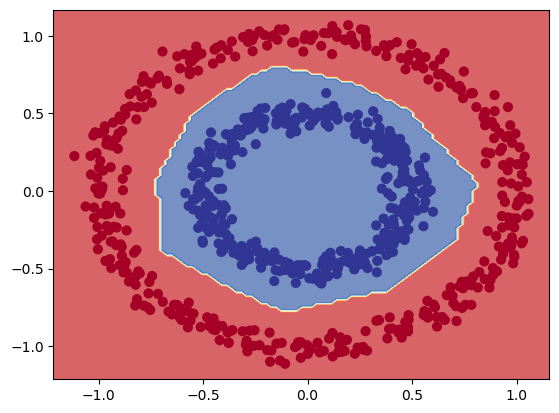

In [171]:
plot_decision_boundary(model2,X_train,y_train)

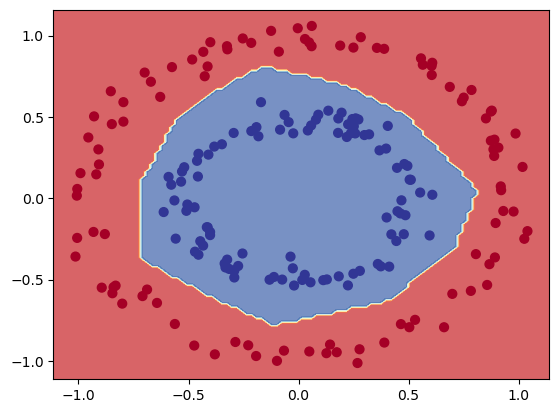

In [172]:
plot_decision_boundary(model2,X_test,y_test)

### Multi-class Classification

In [173]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from helper_function import plot_predictions


torch.__version__


'2.6.0+cpu'

In [174]:
X, y = make_blobs(n_samples=1000, centers=4, n_features=2,
                random_state=42)

X = torch.from_numpy(X).to(torch.float)
y = torch.from_numpy(y).type(torch.float)
X.dtype,y.dtype

(torch.float32, torch.float32)

In [175]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [176]:
# plot_predictions(X_train,y_train,X_test,y_test)
len(X_train),len(y_train),len(X_test),len(y_test)

(800, 800, 200, 200)

In [177]:
len(X),len(y)

(1000, 1000)

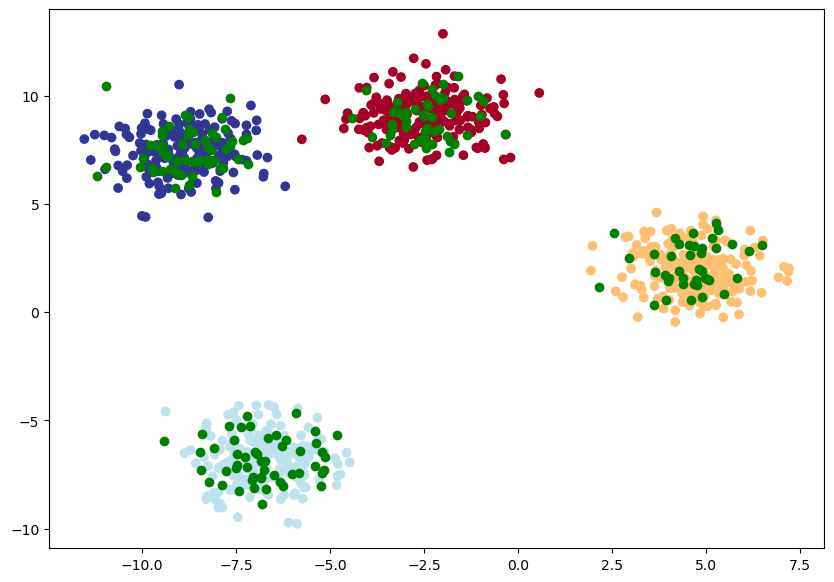

In [178]:
# plot_predictions(X_train[:,0],X_train[:,1],X_test[:,0],X_test[:,1])

plt.figure(figsize=(10,7))
plt.scatter(X_train[:,0],X_train[:,1],c=y_train,cmap=plt.cm.RdYlBu)

plt.scatter(X_test[:,0],X_test[:,1],c="g")
plt.show()


In [179]:
# now we have to create a multiClass Classification model for this dataset

class MultiClassClassification(nn.Module):
    """docstring for MultiClassClassification."""
    def __init__(self):
        super(MultiClassClassification, self).__init__()
        self.linear_layer_1 = nn.Linear(in_features=2, out_features=10)
        self.linear_layer_2 = nn.Linear(in_features=10, out_features=10)
        self.linear_layer_3 = nn.Linear(in_features=10, out_features=4)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        return self.linear_layer_3(self.relu(self.linear_layer_2(self.relu(self.linear_layer_1(x)))))

    

In [180]:
model_3 = MultiClassClassification().to(device)
model_3.state_dict()

OrderedDict([('linear_layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('linear_layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('linear_layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  

In [181]:
# loss/ optimization function 

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_3.parameters(),lr=0.01)

In [182]:
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

In [183]:
# model_3.eval()
# with torch.inference_mode():
#  y_pred = model_3(X_test)
#  y_pred_prob = torch.softmax(y_pred,dim=1)
#  y_pred_prob = torch.argmax(y_pred_prob,dim=1)



In [184]:
# training and test loop 
epochs = 300

for epoch in range(epochs):
    model_3.train() # model in train mood which will activate dropout and batchnorm layer advantage to model during training
    # logits are raw output of the model
    
    # forward pass
    y_pred_logits = model_3(X_train)
    y_pred_label = torch.argmax(torch.softmax(y_pred_logits,dim=1),dim=1)
    
    loss = loss_fn(y_pred_logits, y_train.type(torch.long))
    acc = accuracy(y_pred_label , y_train)
    
    
    # backpropagation
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    
    # testing 
    model_3.eval()
    with torch.inference_mode():
        y_test_logits = model_3(X_test).squeeze()
        
        test_loss = loss_fn(y_test_logits,y_test.to(torch.long))
        y_test_pred = torch.argmax( torch.softmax(y_test_logits,dim=1),dim=1)
        
        # torch.softmax().argmax(dim=1 )
        
        test_acc = accuracy(y_test_pred , y_test)
        
    
    
    if epoch % 10 == 0:
        
        print(f"Epoch: {epoch} loss:{loss:.5f} accuracy: {acc}%  test loss: {test_loss:.5f} test_accuracy: {test_acc}% ")
    
    


Epoch: 0 loss:1.50725 accuracy: 0.875%  test loss: 1.48975 test_accuracy: 0.0% 
Epoch: 10 loss:1.41270 accuracy: 0.125%  test loss: 1.41222 test_accuracy: 0.0% 
Epoch: 20 loss:1.37055 accuracy: 0.0%  test loss: 1.37662 test_accuracy: 0.0% 
Epoch: 30 loss:1.33392 accuracy: 2.125%  test loss: 1.34497 test_accuracy: 1.5% 
Epoch: 40 loss:1.29744 accuracy: 15.000000953674316%  test loss: 1.31319 test_accuracy: 16.5% 
Epoch: 50 loss:1.25814 accuracy: 47.75%  test loss: 1.27866 test_accuracy: 43.0% 
Epoch: 60 loss:1.21484 accuracy: 51.0%  test loss: 1.24004 test_accuracy: 45.0% 
Epoch: 70 loss:1.16603 accuracy: 51.125%  test loss: 1.19594 test_accuracy: 45.0% 
Epoch: 80 loss:1.11116 accuracy: 51.25%  test loss: 1.14608 test_accuracy: 45.0% 
Epoch: 90 loss:1.05074 accuracy: 51.25%  test loss: 1.08989 test_accuracy: 45.0% 
Epoch: 100 loss:0.98627 accuracy: 58.0%  test loss: 1.03005 test_accuracy: 57.0% 
Epoch: 110 loss:0.92432 accuracy: 64.375%  test loss: 0.97181 test_accuracy: 58.999996185302

In [193]:
# model evaluation 

model_3.eval()

with torch.inference_mode():
    y_test_logits = model_3(X_test)
    y_test_pred_label = torch.softmax(y_test_logits,dim=1).argmax(dim=1)
    test_accy = accuracy(y_test_pred_label , y_test)
    print(test_accy)
    


tensor(100.)


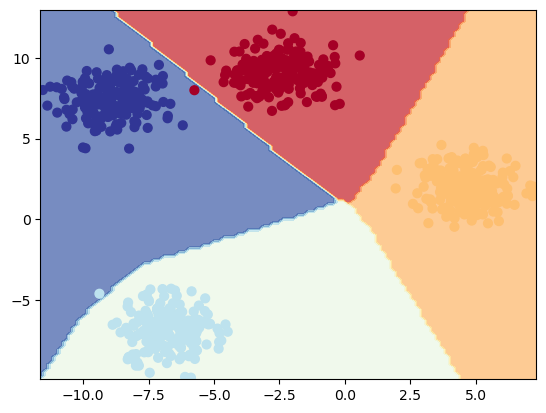

In [185]:


plot_decision_boundary(model_3,X_train,y_train)

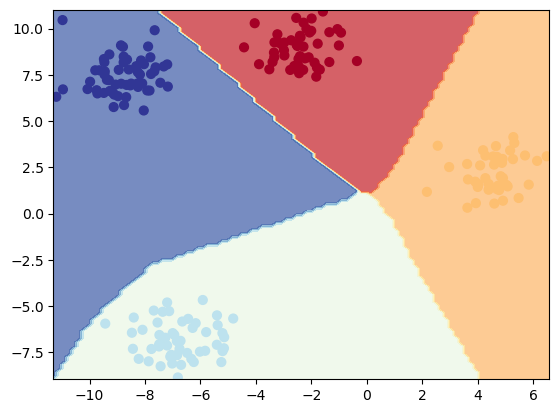

In [186]:

plot_decision_boundary(model_3,X_test,y_test)

In [196]:
# Evalutaion metrix 

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

accuracy_score(y_test, y_test_pred_label)

1.0

In [197]:
print(classification_report(y_test, y_test_pred_label))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        49
         1.0       1.00      1.00      1.00        41
         2.0       1.00      1.00      1.00        53
         3.0       1.00      1.00      1.00        57

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [198]:
confusion_matrix(y_test, y_test_pred_label)

array([[49,  0,  0,  0],
       [ 0, 41,  0,  0],
       [ 0,  0, 53,  0],
       [ 0,  0,  0, 57]])

In [206]:
# pytorch library for model Evaluation!!!

from torchmetrics import Accuracy,Precision,classification,ConfusionMatrix
accuracy = Accuracy(task="multiclass", num_classes=4)
accuracy(y_test_pred_label, y_test)

tensor(1.)

In [201]:
precision = Precision(task="multiclass", average='macro', num_classes=4)
precision(y_test_pred_label, y_test)

tensor(1.)

In [205]:
# multiclassPrecision 

mcp = classification.MulticlassPrecision(num_classes=4, average=None)
mcp(y_test_pred_label, y_test)

tensor([1., 1., 1., 1.])

In [207]:
confmat = ConfusionMatrix(task="multiclass", num_classes=4)
confmat(y_test_pred_label, y_test)

tensor([[49,  0,  0,  0],
        [ 0, 41,  0,  0],
        [ 0,  0, 53,  0],
        [ 0,  0,  0, 57]])